<a href="https://colab.research.google.com/github/mau-arrieta/Doc-Anonymizer/blob/main/Inference_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pipeline SetUp**

In [ ]:
!pip install ultralytics opencv-python tqdm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
!pip -q install -U "spacy>=3.8.0"
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 125.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import json
import shutil
from pathlib import Path
import requests
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from google.colab import drive
import zipfile
import subprocess
import time
import yaml
from collections import defaultdict
from ultralytics import YOLO
from PIL import Image, ImageDraw
import random
import torch
import matplotlib.pyplot as plt

print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPU disponible: True
GPU: Tesla T4


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Computer Vision**

## **1. Model Loading**

### Classes declaration

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign
import torch.nn as nn
from collections import OrderedDict


class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn_pre_nms_top_n_train=3000, rpn_pre_nms_top_n_test=2000, #Updated to 3000 taking into consideration the max amount of words per page
                 rpn_post_nms_top_n_train=3000, rpn_post_nms_top_n_test=2000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=200,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None, num_classes=3):
                  #num_classes used to be 91... testing
        super().__init__()
        # First, set the backbone that we will use to extract the feature maps
        self.backbone = backbone

        out_channels = backbone.out_channels
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

        # Declare the anchor generator of the Region Proposal Network (RPN)
        rpn_anchor_generator = AnchorGenerator(
            anchor_sizes, aspect_ratios
        )

        # Declare the Head of the RPN that will classify the proposals
        rpn_head = RPNHead(
            out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
        )
        rpn_pre_nms_top_n = {"training": rpn_pre_nms_top_n_train, "testing": rpn_pre_nms_top_n_test}
        rpn_post_nms_top_n = {"training": rpn_post_nms_top_n_train, "testing": rpn_post_nms_top_n_test}

        # Create the RPN combining the anchor generator and the head
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        # ROI Align
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)

        resolution = box_roi_pool.output_size[0]
        representation_size = 1024

        # Simple Head made of 2 Fully Connected layers
        box_head = None #we will set them in the exercises

        representation_size = 1024

        # Predictor with 2 outputs (scores and Bounding Boxes deltas)
        box_predictor = None #we will set them in the exercises

        # Module that combines the last modules to compute the prediction of every box and match
        # targets and proposalt in training
        self.roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)
        min_size=800
        max_size=1333
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]

        # Module that does the correct data augmentation
        self.transform = GeneralizedRCNNTransform(min_size, max_size, self.image_mean, self.image_std)

    def forward(self, images, targets=None):
      if self.training and targets is None:
          raise ValueError("In training mode, targets should be passed")

      original_image_sizes = [img.shape[-2:] for img in images]

      images, targets = self.transform(images, targets)
      features = self.backbone(images.tensors)
      if isinstance(features, torch.Tensor):
          features = OrderedDict([('0', features)])

      proposals, proposal_losses = self.rpn(images, features, targets)
      detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)

      losses = {}
      losses.update(detector_losses)
      losses.update(proposal_losses)

      if self.training:
          return losses  # <--- only return losses
      else:
          detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)
          return detections,losses


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Arguments:
        in_size (int): number of inputs
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_size, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_size, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        # Flatten the input tensor: [batch, 256, 7, 7] -> [batch, 256*7*7]
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

In [ ]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Arguments:
        in_size (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_size, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_size, num_classes)
        self.bbox_pred = nn.Linear(in_size, 4 * num_classes)

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

### Backbone Loading & Wandb artifact weights load

In [ ]:
# 1. Load Backbone and create model
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone = resnet_fpn_backbone('resnet18', pretrained=True)
modelCV = FasterRCNN(backbone, num_classes=3)  # 2 classes + background

# 2. Modify the head for the number of classes
in_size = 256*7*7
representation_size = 1024
num_classes = 13 #used to be 91
modelCV.roi_heads.box_head = TwoMLPHead(in_size, representation_size)
modelCV.roi_heads.box_predictor = FastRCNNPredictor(representation_size, num_classes)

In [ ]:
import wandb
import torch

# 1. Init wandb
wandb.init(project="Computer_Vision")

# 2. Get artifact and download
artifact = wandb.use_artifact('adriabuil-upc/Computer_Vision/Resnet18-10k-vebxxwlq0:v0', type='model')
artifact_dir = artifact.download()

# 3. Load checkpoint (state dict)
checkpoint_path = f"{artifact_dir}/model.pth"  # or whatever file you stored
state_dict = torch.load(checkpoint_path, map_location=device)

# 4. Load it into your custom model
modelCV.load_state_dict(state_dict, strict=False)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: toninoguerarecasens (adriabuil-upc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact Resnet18-10k-vebxxwlq0:v0, 108.18MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0 (36.5MB/s)


<All keys matched successfully>

### Model attach to device and set to evaluation mode

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelCV.to(device).eval()
print(type(modelCV))

<class '__main__.FasterRCNN'>


## **2. Model Inference**

### Utils to store inference results in the expected format for the

In [ ]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

def extract_crops(image_tensor, prediction, score_threshold=0.55):
    """
    image_tensor : torch.Tensor (3, H, W)  – original RGB image
    prediction   : dict with keys "boxes", "scores", ...
    Returns      : list of dicts  [{ "crop": PIL.Image, "bbox": (x1,y1,x2,y2) }, …]
    """
    boxes   = prediction["boxes"]
    scores  = prediction["scores"]
    image_pil = to_pil_image(image_tensor.cpu())

    out = []
    for box, score in zip(boxes, scores):
        if score < score_threshold:
            continue
        x1, y1, x2, y2 = map(int, box.tolist())
        crop = image_pil.crop((x1, y1, x2, y2))
        out.append({"crop": crop, "bbox": (x1, y1, x2, y2)})
    return out


def show_crops(crop_items):
    """
    crop_items : list returned by `extract_crops`
    Shows every crop vertically with a thin border.
    """
    if not crop_items:
        print("No crops to display.")
        return

    padded = [ImageOps.expand(item["crop"], border=5, fill="black") for item in crop_items]

    total_h = sum(img.height for img in padded) + 10 * len(padded)
    max_w   = max(img.width  for img in padded)

    canvas = Image.new("RGB", (max_w, total_h), "white")

    y = 0
    for img in padded:
        canvas.paste(img, (0, y))
        y += img.height + 10

    plt.figure(figsize=(8, total_h // 100))
    plt.imshow(canvas)
    plt.axis("off"); plt.show()

### Upload image + inference

In [ ]:
from google.colab import files
import io, torch
from PIL import Image
import torchvision.transforms as T

uploaded = files.upload()
fname = next(iter(uploaded))
print(f"Inference over: {fname}")

Saving 203.tar_1610.06943.gz_GeneralizationSA20160722_4_ori.jpg to 203.tar_1610.06943.gz_GeneralizationSA20160722_4_ori.jpg
Inference over: 203.tar_1610.06943.gz_GeneralizationSA20160722_4_ori.jpg


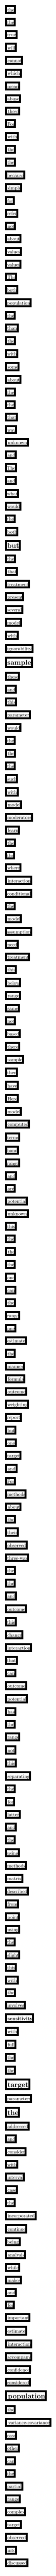

In [ ]:
# --- 1. Convert to the same tensor format your model expects ---------------

transform = T.Compose([
    T.ToTensor(),
])

pil_img = Image.open(io.BytesIO(uploaded[fname])).convert("RGB")
image   = transform(pil_img)         # torch.Tensor (3,H,W)

# store a copy on the local memory
original_image_tensor = image.clone()

# --- 2. Inference ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image  = image.to(device)

with torch.no_grad():
    detections, _ = modelCV([image])   # model returns (detections, losses)
    prediction = detections[0]    # dict for this single image

# --- 3. Crop extraction & visualisation -------------------------------------
croppedCVOutput = extract_crops(original_image_tensor, prediction,
                                score_threshold=0.4)
show_crops(croppedCVOutput)

In [ ]:
id2crop_word = {
    idx: {
        "crop": item["crop"].convert("RGB"),   # ensure PIL RGB
        "bbox": item["bbox"],                  # (x1, y1, x2, y2)
        "text": ""                             # will hold the recognised text
    }
    for idx, item in enumerate(croppedCVOutput)   # croppedCVOutput from extract_crops
}

# quick sanity-check
first = next(iter(id2crop_word.values()))
print("first bbox:", first["bbox"], "| image size:", first["crop"].size)

first bbox: (90, 548, 108, 561) | image size: (18, 13)


# **OCR**

## **1. Model Loading**

### Import lightweight dependencies

In [ ]:
import os, torch, wandb
import torch.nn as nn
import torch.nn.functional as F

### Network building blocks

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, s, p, with_bn=True):
        super().__init__()
        layers = [nn.Conv2d(in_ch, out_ch, k, s, p)]
        if with_bn:
            layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.rnn = nn.LSTM(in_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc  = nn.Linear(hidden_dim * 2, out_dim)

    def forward(self, x):
        # x: (B, T, in_dim)
        x, _ = self.rnn(x)
        # shape after Bi-LSTM: (B, T, hidden_dim*2)
        x = self.fc(x)          # (B, T, out_dim)
        return x

### Full CRNN + 2-layer Bi-LSTM

In [ ]:
class CRNN_BiLSTM(nn.Module):
    """
    A standard CRNN for scene/text OCR:
      CNN backbone reduces H from 32 -> 1, keeps variable W
      Two Bi-LSTM layers map feature sequences to character logits
    """
    def __init__(self,
                 img_height   = 32,
                 num_channels = 1,
                 num_classes  = 96,     # will be overridden once ckpt is seen
                 lstm_hidden  = 256):
        super().__init__()

        assert img_height == 32, "this backbone assumes 32-pixel input height"

        self.cnn = nn.Sequential(
            ConvBlock(num_channels, 64,  3, 1, 1, with_bn=False), # 32x → 32x
            nn.MaxPool2d(2, 2),                                   # 32→16

            ConvBlock(64, 128, 3, 1, 1),                          # 16x
            nn.MaxPool2d(2, 2),                                   # 16→8

            ConvBlock(128, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
            nn.MaxPool2d((2,1), (2,1), (0,0)),                    # 8→4 (H only)

            ConvBlock(256, 512, 3, 1, 1),
            ConvBlock(512, 512, 3, 1, 1),
            nn.MaxPool2d((2,1), (2,1), (0,0)),                    # 4→2 (H only)

            ConvBlock(512, 512, 2, 1, 0)                          # 2→1
        )

        self.map2seq     = nn.Conv2d(512, 512, 1, 1, 0)  # just reshape C if needed
        self.rnn         = nn.Sequential(
                                BidirectionalLSTM(512, lstm_hidden, lstm_hidden),
                                BidirectionalLSTM(lstm_hidden, lstm_hidden, num_classes)
                           )

    def forward(self, x):
        # x: (B, C=1, H=32, W)
        conv = self.cnn(x)                   # (B, 512, 1, W')
        conv = self.map2seq(conv)            # (B, 512, 1, W')
        conv = conv.squeeze(2)               # (B, 512, W')
        conv = conv.permute(0, 2, 1)         # (B, W', 512)  -> time-major

        logits = self.rnn(conv)              # (B, W', num_classes)
        # most OCR decoders expect log-softmax over classes
        return F.log_softmax(logits, dim=-1)

### Download checkpoint from W&B

In [ ]:
import os, torch, wandb

wandb.login()
run = wandb.init(project="OCR", job_type="inference", anonymous="allow")

artifact_name = "adriabuil-upc/OCR/best_model_CRNN_BiLSTM_25000_imgs.pth:v7"
artifact      = run.use_artifact(artifact_name, type="model")
ckpt_dir      = artifact.download()
ckpt_path     = os.path.join(ckpt_dir, "best_model_CRNN_BiLSTM_25000_imgs.pth")
print("✔︎ checkpoint downloaded →", ckpt_path)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb:   1 of 1 files downloaded.  


✔︎ checkpoint downloaded → /content/artifacts/best_model_CRNN_BiLSTM_25000_imgs.pth:v7/best_model_CRNN_BiLSTM_25000_imgs.pth


In [ ]:
raw = torch.load(ckpt_path, map_location="cpu")

# unwrap common checkpoint formats
if isinstance(raw, dict) and "state_dict" in raw:                 # PyTorch-Lightning, etc.
    state_dict = raw["state_dict"]
elif isinstance(raw, dict) and "model" in raw and isinstance(raw["model"], dict):
    state_dict = raw["model"]                                     # custom save dict
else:
    state_dict = raw                                              # plain state_dict

# strip "module." prefix if saved with DataParallel / DDP
state_dict = {k[7:] if k.startswith("module.") else k: v
              for k, v in state_dict.items()}

In [ ]:
fc_keys  = [k for k in state_dict if k.endswith((".fc.weight", ".linear.weight"))]
cand2d   = [k for k, v in state_dict.items() if v.ndim == 2 and v.shape[0] != v.shape[1]]
candidates = fc_keys or cand2d

if not candidates:
    raise RuntimeError("Could not find any 2-D weight tensors. "
                       "Inspect state_dict and set `num_classes` manually.")

# choose the layer whose row-count is *smallest* (typically = alphabet size)
best_key   = min(candidates, key=lambda k: state_dict[k].shape[0])
num_classes = state_dict[best_key].shape[0]

print(f"Detected num_classes = {num_classes}  (from '{best_key}' → {tuple(state_dict[best_key].shape)})")


Detected num_classes = 63  (from 'embedding.weight' → (63, 512))


### Instantiate Network & load Weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelOCR = CRNN_BiLSTM(img_height=32,
                    num_channels=1,
                    num_classes=num_classes,
                    lstm_hidden=256)

missing, unexpected = modelOCR.load_state_dict(state_dict, strict=False)
print(f"State-dict loaded with {len(missing)} missing and {len(unexpected)} "
      f"unexpected keys.")
if missing:
    print("  • Missing keys:", missing[:5], "..." if len(missing) > 5 else "")
if unexpected:
    print("  • Unexpected keys:", unexpected[:5], "..." if len(unexpected) > 5 else "")

modelOCR.to(device).eval()
print("✅ Model ready on", device)

State-dict loaded with 60 missing and 58 unexpected keys.
  • Missing keys: ['cnn.0.block.0.weight', 'cnn.0.block.0.bias', 'cnn.2.block.0.weight', 'cnn.2.block.0.bias', 'cnn.2.block.1.weight'] ...
  • Unexpected keys: ['embedding.weight', 'embedding.bias', 'cnn.0.conv.0.weight', 'cnn.0.conv.0.bias', 'cnn.0.conv.1.weight'] ...
✅ Model ready on cuda


## **2. Model Inference**

### Imports

In [ ]:
import string, torch
from torchvision import transforms as T
from PIL import Image

### Alphabet & helpers

In [ ]:
punct = ''.join(chr(c) for c in range(32, 127) if not chr(c).isalnum())  # 33 chars incl. space
alphabet = string.digits + string.ascii_lowercase + string.ascii_uppercase + punct

blank_idx = 0
idx2char  = {i + 1: ch for i, ch in enumerate(alphabet)}  # 1-based because 0 = blank

def ctc_greedy_decode(log_probs):
    """
    Greedy CTC decoder: collapses repeats and removes blanks.
    log_probs: (T, C) tensor after log-softmax
    """
    best = log_probs.argmax(dim=-1).cpu().tolist()        # indices over time
    out, prev = [], None
    for idx in best:
        if idx != prev and idx != blank_idx:
            out.append(idx2char[idx])
        prev = idx
    return ''.join(out)

### Pre-processing

In [ ]:
device = next(modelOCR.parameters()).device          # same device as the model

def pil_to_tensor(pil_img, out_h=32):
    """
    Resizes to fixed height (32 px) while keeping aspect ratio,
    converts to [0,1] float tensor shaped (1, H, W) and right-pads
    width so it’s a multiple of 4 (CNN down-sampling factor).
    """
    w, h = pil_img.size
    new_w = int(w * out_h / h)
    img = pil_img.resize((new_w, out_h), Image.BILINEAR).convert('L')  # grayscale
    tensor = T.ToTensor()(img)                                         # (1, 32, new_w)

    pad_w = (4 - new_w % 4) % 4
    if pad_w:
        tensor = torch.nn.functional.pad(tensor, (0, pad_w))

    return tensor

### Inference loop

In [ ]:
modelOCR.eval()
with torch.no_grad():
    for idx, entry in id2crop_word.items():
        pil_img = entry["crop"]                                   # PIL.Image
        display(pil_img)
        tensor  = pil_to_tensor(pil_img).unsqueeze(0).to(device)  # (1,1,32,W)

        logits = modelOCR(tensor)       # common shapes: (1,T,C)  OR  (T,1,C)

        # --- make sure logits is (T, C) before decoding ----------
        if logits.dim() == 3 and logits.shape[0] == 1:
            logits = logits.squeeze(0)            # (T, C)
        elif logits.dim() == 3 and logits.shape[1] == 1:
            logits = logits.squeeze(1)            # (T, C)
        elif logits.dim() != 2:
            raise ValueError(f"Unexpected logits shape: {logits.shape}")

        pred_txt = ctc_greedy_decode(logits)      # greedy CTC → string
        entry["text"] = pred_txt                  # store prediction directly
        print(f"[{idx}] → '{pred_txt}'")        # ← enable for debugging

print(f"OCR done for {len(id2crop_word)} crops ✅")
first_key = next(iter(id2crop_word))
print(id2crop_word[first_key])

[0] → ''


[1] → ''


[2] → ''


[3] → ''


[4] → ''


[5] → ''


[6] → ''


[7] → ''


[8] → ''


[9] → ''


[10] → ''


[11] → ''


[12] → ''


[13] → ''


[14] → ''


[15] → ''


[16] → ''


[17] → ''


[18] → ''


[19] → ''


[20] → ''


[21] → ''


[22] → ''


[23] → ''


[24] → ''


[25] → ''


[26] → ''


[27] → ''


[28] → ''


[29] → ''


[30] → ''


[31] → ''


[32] → ''


[33] → ''


[34] → ''


[35] → ''


[36] → ''


[37] → ''


[38] → ''


[39] → ''


[40] → ''


[41] → ''


[42] → ''


[43] → ''


[44] → ''


[45] → ''


[46] → ''


[47] → ''


[48] → ''


[49] → ''


[50] → ''


[51] → ''


[52] → ''


[53] → ''


[54] → ''


[55] → ''


[56] → ''


[57] → ''


[58] → ''


[59] → ''


[60] → ''


[61] → ''


[62] → ''


[63] → ''


[64] → ''


[65] → ''


[66] → ''


[67] → ''


[68] → ''


[69] → ''


[70] → ''


[71] → ''


[72] → ''


[73] → ''


[74] → ''


[75] → ''


[76] → ''


[77] → ''


[78] → ''


[79] → ''


[80] → ''


[81] → ''


[82] → ''


[83] → ''


[84] → ''


[85] → ''


[86] → ''


[87] → ''


[88] → ''


[89] → ''


[90] → ''


[91] → ''


[92] → ''


[93] → ''


[94] → ''


[95] → ''


[96] → ''


[97] → ''


[98] → ''


[99] → ''


[100] → ''


[101] → ''


[102] → ''


[103] → ''


[104] → ''


[105] → ''


[106] → ''


[107] → ''


[108] → ''


[109] → ''


[110] → ''


[111] → ''


[112] → ''


[113] → ''


[114] → ''


[115] → ''


[116] → ''


[117] → ''


[118] → ''


[119] → ''


[120] → ''


[121] → ''


[122] → ''


[123] → ''


[124] → ''


[125] → ''


[126] → ''


[127] → ''


[128] → ''


[129] → ''


[130] → ''


[131] → ''


[132] → ''


[133] → ''


[134] → ''


[135] → ''


[136] → ''


[137] → ''


[138] → ''


[139] → ''


[140] → ''


[141] → ''


[142] → ''


[143] → ''


[144] → ''


[145] → ''


[146] → ''


[147] → ''


[148] → ''


[149] → ''


[150] → ''


[151] → ''


[152] → ''


[153] → ''


[154] → ''


[155] → ''


[156] → ''


[157] → ''


[158] → ''


[159] → ''


[160] → ''


[161] → ''


[162] → ''


[163] → ''


[164] → ''


[165] → ''


[166] → ''


[167] → ''


[168] → ''


[169] → ''


[170] → ''


[171] → ''


[172] → ''


[173] → ''


[174] → ''


[175] → ''


[176] → ''


[177] → ''


[178] → ''


[179] → ''


[180] → ''


[181] → ''


[182] → ''


[183] → ''


[184] → ''


[185] → ''


[186] → ''


[187] → ''


[188] → ''


[189] → ''


[190] → ''


[191] → ''


[192] → ''


[193] → ''


[194] → ''


[195] → ''


[196] → ''


[197] → ''


[198] → ''


[199] → ''
OCR done for 200 crops ✅
{'crop': <PIL.Image.Image image mode=RGB size=18x13 at 0x7C3B16B18D50>, 'bbox': (90, 548, 108, 561), 'text': ''}


# NLP

## Model Load

In [ ]:
import spacy, torch

USE_GPU = torch.cuda.is_available()
if USE_GPU:
    spacy.require_gpu()


nlp = spacy.load("en_core_web_sm")

print("Pipeline components:", nlp.pipe_names)


Pipeline components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


## Classifier

In [ ]:
# id2crop_word already exists from your image → OCR stage
# Each entry looks like:  {"crop": PIL.Image, "text": "OCR-string"}

def classify_texts(id2crop_word, nlp, batch_size=64, keep_ocr=True):
    """Run spaCy text classification (or NER/POS) on the words in the dict."""
    keys   = list(id2crop_word.keys())
    texts  = [id2crop_word[k]["text"] for k in keys]

    # Fast, streaming inference
    docs = list(nlp.pipe(texts, batch_size=batch_size))

    for k, doc in zip(keys, docs):
        if "textcat" in nlp.pipe_names:
            label = max(doc.cats, key=doc.cats.get)
        else:
            label = doc.ents[0].label_ if doc.ents else "NONE"

        if keep_ocr:
            id2crop_word[k]["model_label"] = label
        else:
            id2crop_word[k]["text"] = label

    return id2crop_word

id2crop_word = classify_texts(id2crop_word, nlp)


In [ ]:
id2crop_word

# Blur Picture

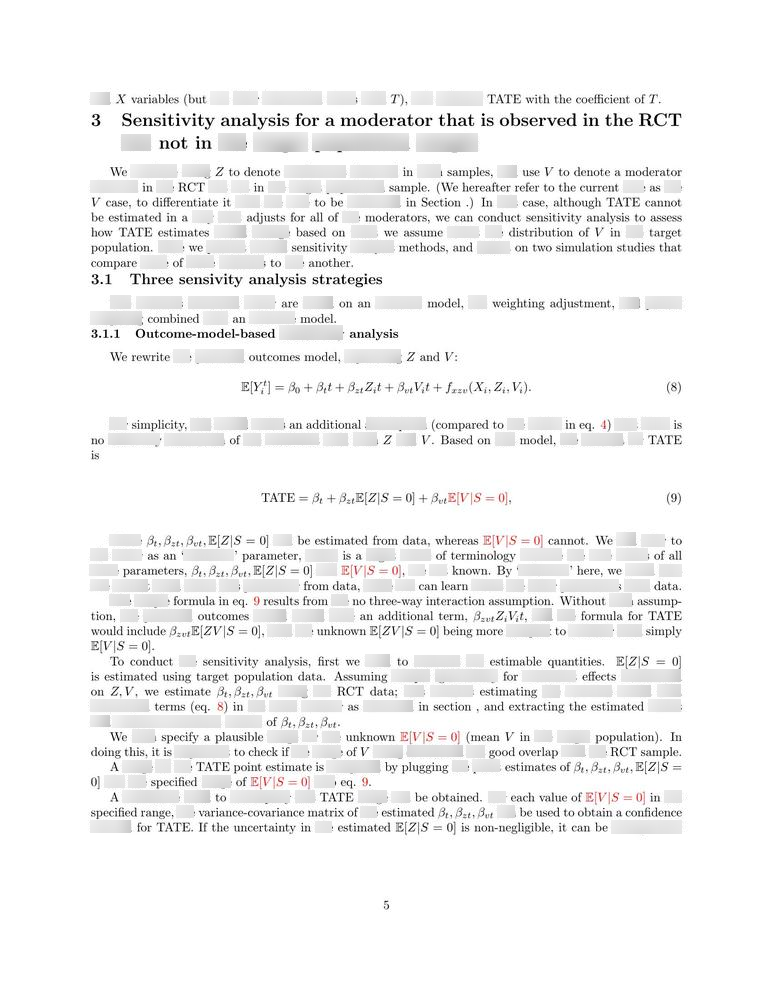

In [ ]:
from torchvision.transforms.functional import to_pil_image
from PIL import ImageFilter, Image

def blur_bboxes_on_image(image_tensor, id2crop_word, radius=6):
    """
    image_tensor : torch.Tensor (3, H, W)  – original RGB image in [0-1] or [0-255]
    id2crop_word : dict                     – must contain "bbox" = (x1, y1, x2, y2)
    radius       : Gaussian-blur radius (pixels)

    Returns      : PIL.Image with every bbox region blurred
    """
    # 1. tensor ➜ PIL so we can use ImageFilter
    img = to_pil_image(image_tensor.cpu()).convert("RGB")
    W, H = img.size

    for entry in id2crop_word.values():
        x1, y1, x2, y2 = map(int, entry["bbox"])

        # clamp to image bounds in case a box hangs outside
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(W, x2), min(H, y2)
        if x2 <= x1 or y2 <= y1:           # empty / invalid box
            continue

        # 2. crop → blur → paste back
        region   = img.crop((x1, y1, x2, y2))
        blurred  = region.filter(ImageFilter.GaussianBlur(radius))
        img.paste(blurred, (x1, y1))

    return img

# ---------------------------------------------------------------------------
# Example usage
blurred_pil = blur_bboxes_on_image(original_image_tensor, id2crop_word, radius=8)
display(blurred_pil)          # Jupyter/Colab preview
# blurred_pil.save("blurred_output.jpg")   # save if you like
